# Closed-loop planning with deep reactive policies in JaxPlan.

This rudimentary example compares the performance of a closed-loop and open-loop controller in JaxPlan on a stochastic domain. The closed loop controller learns a policy network that takes the state of the system as input, and produces an action-fluent as output.

In [1]:
%pip install --quiet --upgrade pip
%pip install --quiet seaborn
%pip install --quiet git+https://github.com/pyrddlgym-project/pyRDDLGym.git
%pip install --quiet git+https://github.com/pyrddlgym-project/rddlrepository.git
%pip install --quiet git+https://github.com/pyrddlgym-project/pyRDDLGym-jax.git

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Import the required packages:

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import matplotlib.pyplot as plt
import seaborn as sns

import pyRDDLGym
from pyRDDLGym_jax.core.planner import JaxBackpropPlanner, JaxOfflineController, load_config_from_string

We will optimize the stochastic Wildfire problem from IPPC 2014. Note again the use of the ``vectorized`` option:

In [3]:
env = pyRDDLGym.make('Wildfire_MDP_ippc2014', '1', vectorized=True)

Let's generate a baseline using the straightline planner, and see if we can improve upon it:

In [4]:
config = """
[Model]
comparison_kwargs={'weight': 100}
rounding_kwargs={'weight': 100}
control_kwargs={'weight': 100}
[Optimizer]
method='JaxStraightLinePlan'
optimizer_kwargs={'learning_rate': 0.1}
pgpe=None
[Training]
key=42
"""
planner_args, _, train_args = load_config_from_string(config)
planner = JaxBackpropPlanner(rddl=env.model, **planner_args)
agent = JaxOfflineController(planner, print_summary=False, train_seconds=20, **train_args)
slp_returns = [agent.evaluate(env, episodes=1)['mean'] for _ in range(100)]

[INFO] JAX gradient compiler will cast p-vars {'out-of-fuel', "out-of-fuel'", 'NEIGHBOR', "burning'", 'cut-out', 'burning', 'put-out', 'TARGET'} to float.
[INFO] JAX gradient compiler will cast CPFs {"out-of-fuel'", "burning'"} to float.
[INFO] Bounds of action-fluent <put-out> set to (None, None).
[INFO] Bounds of action-fluent <cut-out> set to (None, None).
[INFO] SLP will use projected gradient to satisfy max_nondef_actions since total boolean actions 18 > max_nondef_actions 1.
[WARN] policy_hyperparams is not set, setting 1.0 for all action-fluents which could be suboptimal.


      0 it /    -2886.56128 train /    -7565.78125 test /    -7565.78125 best / 0 status /      0 pgpe:  14%|█▍        | 00:02 , 0.36it/s

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


   2067 it /     -590.05505 train /    -1115.23438 test /     -707.01562 best / 5 status /      0 pgpe: 100%|██████████| 00:19 , 103.38it/s


Let's now generate the policy network. Note the slight difference in the config file arguments:

In [5]:
config = """
[Model]
comparison_kwargs={'weight': 100}
rounding_kwargs={'weight': 100}
control_kwargs={'weight': 100}
[Optimizer]
method='JaxDeepReactivePolicy'
method_kwargs={'topology': [128, 64]}
optimizer_kwargs={'learning_rate': 0.001}
pgpe=None
[Training]
key=42
"""
planner_args, _, train_args = load_config_from_string(config)
planner = JaxBackpropPlanner(rddl=env.model, **planner_args)
agent = JaxOfflineController(planner, print_summary=False, train_seconds=20, **train_args)
drp_returns = [agent.evaluate(env, episodes=1)['mean'] for _ in range(100)]

[INFO] JAX gradient compiler will cast p-vars {'out-of-fuel', "out-of-fuel'", 'NEIGHBOR', "burning'", 'cut-out', 'burning', 'put-out', 'TARGET'} to float.
[INFO] JAX gradient compiler will cast CPFs {"out-of-fuel'", "burning'"} to float.
[INFO] Bounds of action-fluent <put-out> set to (None, None).
[INFO] Bounds of action-fluent <cut-out> set to (None, None).
[WARN] policy_hyperparams is not set, setting 1.0 for all action-fluents which could be suboptimal.


      0 it /    -3994.27271 train /    -7530.46875 test /    -7530.46875 best / 0 status /      0 pgpe:  17%|█▋        | 00:02 , 0.29it/s

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    932 it /     -423.17322 train /     -544.82812 test /     -229.07812 best / 5 status /      0 pgpe: 100%|██████████| 00:19 , 46.63it/s


Finally, let's plot two overlapping histograms comparing the distribution of returns for the two plans:

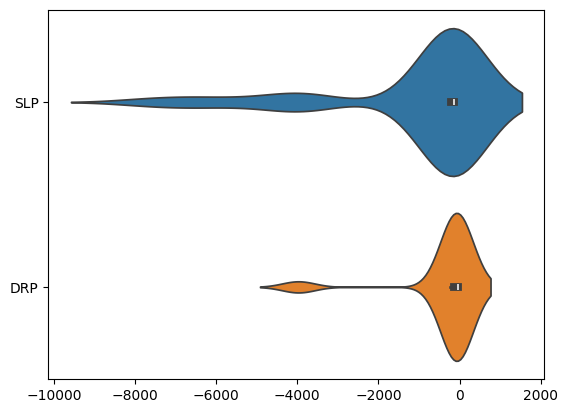

In [6]:
%matplotlib inline
ax = sns.violinplot(data=[slp_returns, drp_returns], orient='h')
ax.set_yticklabels(['SLP', 'DRP'])
plt.show()

As you can see, the reactive policy network has a lower spread in return, and has a much higher probability of generating the optimal return of zero than the straight line planner.